In [1]:
!pip install --upgrade scikit-learn==1.4.1post1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing Notebook: Adding directory to path so it's possible to import scripts

In [3]:
import sys
def GetRoot(user = None):
    '''
    Deterimines what the root path is for google collab.
    Inputs:
    user (str): Name of the person using this notebook.

    Output:
    (str) root path
    '''
    if user.lower() == 'jackie':
        root = '/content/drive/MyDrive/AUTOMATION/DarthImputer(AutomationProject)'
    elif user.lower() == 'thomas':
        root = '/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)'
    elif user.lower() == 'gabe':
        root = '/content/drive/MyDrive/DarthImputer(AutomationProject)'
    else:
        raise Exception("Ya fucked up son. Who are you?")

    return root

root = GetRoot('Thomas')
sys.path.append(f'{root}/src')

In [4]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import helpers
import basic_impute
import basemodel
import afva
import mice
import rfva

from tqdm import tqdm

In [ ]:
importlib.reload(helpers)
importlib.reload(basic_impute)
importlib.reload(basemodel)
importlib.reload(afva)
importlib.reload(mice)
importlib.reload(rfva)

<module 'rfva' from '/content/drive/MyDrive/Colab Notebooks/DarthImputer(AutomationProject)/src/rfva.py'>

# Start here if you need to process the raw data (mask out values and visualize class distribution).

# Step 0) Importing the data

In [5]:
import pandas as pd

# Brain
def ReadData(root, dataset:str='fertility'):
  """
  Input:
    root (str): Path to the root of the project
    dataset (str): Which data set are you using? "brain","lung" or "breast"
  """
  header=0
  if dataset.lower() == 'fertility':
    path = root + '/data/binary/fertility_Diagnosis.txt'
    header=None
  elif dataset.lower() == 'aging':
    path = root + '/data/aging/NPHA-doctor-visits.csv'
  elif dataset.lower() == 'brain':
    path = root + '/data/archive/brain/Brain_GSE50161.csv'
  elif dataset.lower() == 'breast':
    path = root + '/data/archive/breast/Breast_GSE45827.csv'
  elif dataset.lower() == 'lung':
    path = root + '/data/archive/lung/clean/complete_dataframe.csv'
  elif dataset.lower() == 'breast_cancer':
    path = root + '/data/breast_cancer/breast-cancer.data'
    header=None
  else:
    raise Exception("I don't have that dataset you ding dong.")

  data = pd.read_csv(path, header=header)
  return data

# For NPHA (National Poll on Healthy Aging) dataset


In [6]:
# data = ReadData(root, 'aging')
# directory = root + "/data/aging"
# x, y = data.iloc[:,1:].to_numpy().astype(float), data.iloc[:,0].to_numpy()-1
# encoding_to_label = None
# # Saving the feature.
# filepath = directory + '/features.npy'
# np.save(filepath, x)
# # Saving the labels.
# filepath = directory + '/labels.npy'
# np.save(filepath, y)

# For Breast Cancer Dataset

In [7]:
# data = ReadData(root, 'breast_cancer')
# directory = root + "/data/breast_cancer"
# display(data)

In [8]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

# mask = (data[5]=='?')|(data[8]=='?')
# processed_df = data[~mask]
# for col in processed_df:
#   print(processed_df[col].unique())

# all_label_to_encoding = []
# all_encoding_to_label = []
# for col in processed_df:
#   processed_df.loc[:,col] = encoder.fit_transform(processed_df[col])
#   keys = encoder.classes_
#   values = encoder.transform(encoder.classes_)
#   all_label_to_encoding.append(dict(zip(keys, values)))
#   all_encoding_to_label.append(dict(zip(values, keys)))
# x, y = processed_df.iloc[:,1:].to_numpy().astype(float), processed_df.iloc[:,0].to_numpy().astype(int)
# encoding_to_label = all_encoding_to_label[0]
# # Saving the feature.
# filepath = directory + '/features.npy'
# np.save(filepath, x)
# # Saving the labels.
# filepath = directory + '/labels.npy'
# np.save(filepath, y)

## For Fertiility data

In [9]:
fertility_data = ReadData(root, 'fertility')
directory = root + "/data/binary"

header = ['Season', 'Age', 'Childhood disease', 'Accident/Trauma', 'Surgical intervention', 'High fevers in the last year', 'Frequency of alcohol consumption', 'Smoking habit', \
          'Number of hours spent sitting per day', 'Output']
fertility_data.columns = header

Encode the labels 'N' as 0 and 'O' as 1.

In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
processed_data = fertility_data.copy()
processed_data['Output'] = encoder.fit_transform(fertility_data['Output'])
display(fertility_data.head(2), processed_data.head(2))

keys = encoder.classes_
values = encoder.transform(encoder.classes_)
label_to_encoding = dict(zip(keys, values))
encoding_to_label = dict(zip(values, keys))
print(f'The label encoder used the following mapping: {label_to_encoding}.')

,Season,Age,Childhood disease,Accident/Trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O


,Season,Age,Childhood disease,Accident/Trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,0
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,1


The label encoder used the following mapping: {'N': 0, 'O': 1}.


Convert the pandas dataframe into two numpy array. One for features and one for labels.

In [11]:
x, y = processed_data.iloc[:,:-1].to_numpy(), processed_data.iloc[:,-1].to_numpy()
print(x.shape, y.shape)

(100, 9) (100,)


#Step 1) Visualize the data

> Add blockquote



In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_x = pca.fit_transform(x)

In [13]:
if encoding_to_label is not None:
  labels = [(key, value) for key, value in  encoding_to_label.items()]
else:
  labels = [(value, value) for value in np.unique(y)]

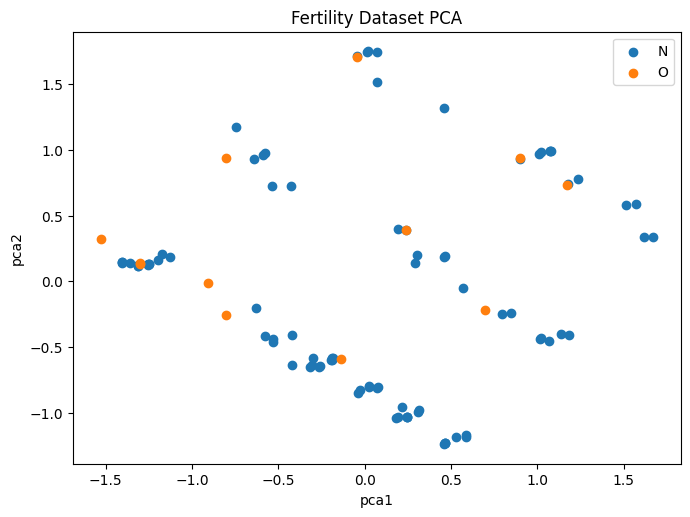

In [17]:
fig = plt.figure()
ax = fig.add_axes(rect=[0.05,0.1,0.95,0.9])

for target, label in labels:
  ridx = np.nonzero(y==target)
  scatter = ax.scatter(pca_x[ridx,0], pca_x[ridx,1], label=label)

ax.legend()
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_title('Fertility Dataset PCA')
plt.show(fig)

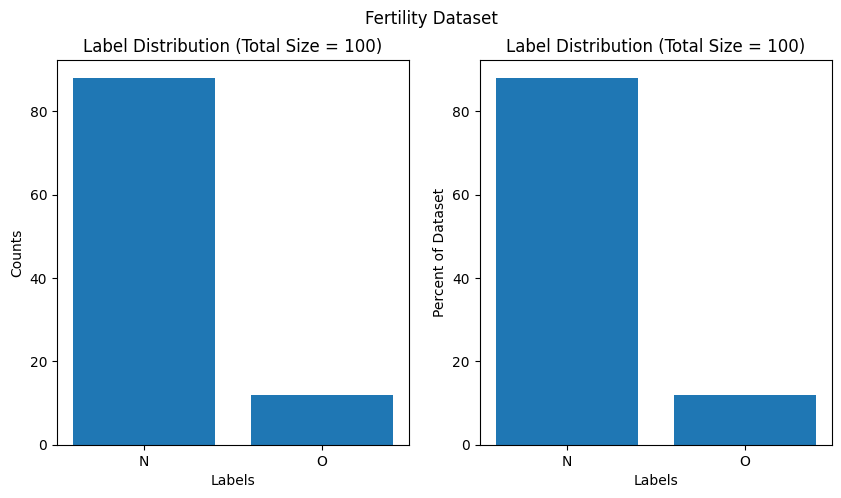

In [16]:
# counts = np.array([np.sum(y==lab) for lab in encoding_to_label.keys()])
counts = np.array([np.sum(y==lab) for lab in np.unique(y)])
num_classes = len(np.unique(y))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
# fig = plt.figure()
# ax = fig.add_axes(rect=[0.05,0.1,0.95,0.9])
ax[0].bar(np.arange(num_classes), counts)
ax[0].set_xticks(range(num_classes))
ax[0].set_xticklabels([val for _, val in labels])
ax[0].set_xlabel('Labels')
ax[0].set_ylabel('Counts')
ax[0].set_title(f'Label Distribution (Total Size = {len(y)})')

ax[1].bar(np.arange(num_classes), 100*counts/counts.sum())
ax[1].set_xticks(range(num_classes))
ax[1].set_xticklabels([val for _, val in labels])
ax[1].set_xlabel('Labels')
ax[1].set_ylabel('Percent of Dataset')
ax[1].set_title(f'Label Distribution (Total Size = {len(y)})')
fig.suptitle('Fertility Dataset')
plt.show(fig)

# Step 2) Prepare the data for simulating active learning.

Assigning some logists variables.

In [ ]:
num_simulations = 10 # Number of simulations
test_proportion = 0.9 # Percentage of the data to use as test set.
proportion1 = 0.3 # Percentage of data to mask
seeds = np.array([174*(i+1) for i in range(num_simulations)])

2.1) Get the row indicies corresponding to the training and testing set.

In [ ]:
# train_idxs and test_idxs should be a "num_simulations" length list
# Each element in train_idxs and test_idxs is a np.ndarray
# The array is the row indicies corresponding to either the training or testing set
# for that simulation.
train_idx_mult_sim, test_idx_mult_sim = [], [] # The traning and testing rows for each simulation
for seed in seeds:
  ds = basemodel.Dataset(x, y, seed)
  train_idxs, test_idxs = ds.split_data(test_proportion, stratify=True)
  train_idx_mult_sim.append(train_idxs)
  test_idx_mult_sim.append(test_idxs)
train_idx_mult_sim = np.array(train_idx_mult_sim)
test_idx_mult_sim = np.array(test_idx_mult_sim)

2.2) For each simulation mask out a portion of the **training** set.

In [ ]:
importlib.reload(helpers)
x_mult_sim = []
percents = np.array([0.1*i for i in range(1,6,1)])
for proportion1 in percents:
  mult_sim = []
  proportion2 = proportion1 if round(proportion1*x.shape[1])>=1 else 1/x.shape[1]
  for i, seed in enumerate(seeds):
    x_cp = x.copy()

    # Uncomment this out and comment out the following line if you want to mask both the training and testing set.
    # x_cp = helpers.Implement_Random_Masking(x_cp, 0.3)
    n = len(train_idx_mult_sim[i])
    x_cp[train_idx_mult_sim[i]] = helpers.Implement_Random_Masking(x_cp[train_idx_mult_sim[i]],
                                                                  proportion1=(n-3)/n,
                                                                  proportion2=proportion2,
                                                                  axis=0,
                                                                  seed=seed)
    x_cp[test_idx_mult_sim[i]] = helpers.Implement_Random_Masking(x_cp[test_idx_mult_sim[i]], proportion1=proportion1, seed=seed)

    # Uncomment this out and comment out the pervious line if you want to mask only the training set.
    # x_cp[train_idx_mult_sim[i]] = helpers.Implement_Random_Masking(x_cp[train_idx_mult_sim[i]], proportion1=proportion1, seed=seed)


    mult_sim.append(x_cp)
  x_mult_sim.append(mult_sim)

x_mult_sim = np.array(x_mult_sim)

2.3) Save the masked data sets, training indicies and testing indicies.

In [ ]:
# Saving the masked data set (features)
filepath = directory + '/masked_features.npy'
np.save(filepath, x_mult_sim)
# Saving the training indexes.
filepath = directory + '/train_idxs.npy'
np.save(filepath, train_idx_mult_sim)
# Saving the testing indexes.
filepath = directory + '/test_idxs.npy'
np.save(filepath, test_idx_mult_sim)
# Saving the mask proportions.
filepath = directory + '/mask_percents.npy'
np.save(filepath, percents)
# Saving the seeds used to generate the masked data.
filepath = directory + '/seeds.npy'
np.save(filepath, seeds)

# Start From Here if you don't need the Raw Data.

# Step 3) Load the masked data and use it to run imputations.

In [ ]:
directory = root + '/data/aging' # Where to get the masked data from.
# Loading unmasked data set
filepath = directory + '/features.npy' # n length array. n = number of samples.
x = np.load(filepath)
# Loading the labels.
filepath = directory + '/labels.npy' # n length array. n = number of samples.
y = np.load(filepath)
# Loading the masked data set (features)
filepath = directory + '/masked_features.npy'
x_mult_sim = np.load(filepath) # Three dimensional (s, n, f). s = number of simulations. n = number of samples. f = number of features.
# Loading the training indexes.
filepath = directory + '/train_idxs.npy'
train_idx_mult_sim = np.load(filepath) # (s, d). s = number of simulations. d = number of samples in the training set.
# Loading the testing indexes.
filepath = directory + '/test_idxs.npy'
test_idx_mult_sim = np.load(filepath) # (s, k). s = number of simulations. k = number of samples in the testing set.
# Loading the seeds.
filepath = directory + '/seeds.npy'
seeds = np.load(filepath)
# Loading the mask percentages.
filepath = directory + '/mask_percents.npy'
percents = np.load(filepath)

In [ ]:
p, s, n, f = x_mult_sim.shape
padding=14
print(f'Proportions of data masked : {percents}')
print(f"Number of {'mask percents':<{padding}}: {p}" +
      f"\nNumber of {'simulations':<{padding}}: {s}"+
      f"\nNumber of {'samples':<{padding}}: {n}"+
      f"\nNumber of {'features':<{padding}}: {f}")
padding=15
print(f"Shape of {'x':<{padding}}: {x_mult_sim.shape}"+
      f"\nShape of {'y':<{padding}}: {y.shape}"+
      f"\nShape of {'train_idxs':<{padding}}: {train_idx_mult_sim.shape}"+
      f"\nShape of {'test_idxs':<{padding}}: {test_idx_mult_sim.shape}")

Proportions of data masked : [0.1 0.2 0.3 0.4 0.5]
Number of mask percents : 5
Number of simulations   : 10
Number of samples       : 277
Number of features      : 9
Shape of x              : (5, 10, 277, 9)
Shape of y              : (277,)
Shape of train_idxs     : (10, 29)
Shape of test_idxs      : (10, 248)


# Looking at masked data

In [ ]:
filepath = directory + '/labels.npy'
labels = np.load(filepath)

filepath = directory + '/masked_features.npy'
masked_data = np.load(filepath)

Check if there are 3 "perfect" rows in the training dataset for each of the masked data sets.

In [ ]:
for i in range(p):
  for j in range(s):
    train_idx = train_idx_mult_sim[j]
    mask = np.isnan(x_mult_sim[i,j,train_idx,:])
    mask = np.sum(mask, axis=1)
    num_perfect_rows = np.sum(mask==0)
    if num_perfect_rows < 3:
      print(f'Number of "perfect" samples: {num_perfect_rows}.')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier()
clf.fit(x,y)
preds = clf.predict(x)
print(accuracy_score(y, preds))

0.9783393501805054


# Step 4) Use mice to impute the missing values

In [ ]:
from sklearn.linear_model import LogisticRegression

def ImputeAllSimulations(x_mult_sim, classifier, seeds):
  """
  x_mult_sim: The nan masked data for each simulation. (s, n, f) matrix.
  classifier: The sklearn regressor/classifier to use for MICE.
  seeds: The seeds that were used to generate x_mult_sim. (s) length vector
  """
  s,n,f = x_mult_sim.shape
  mice_imputed_data = []
  for i in range(s):
    seed = seeds[i]
    full_data = x_mult_sim[i]
    mice_imputed_data.append(mice.ImputeDataMice(full_data, classifier=classifier, threshold = 0.0, seed = seed))
  mice_imputed_data = np.array(mice_imputed_data)

  return mice_imputed_data

In [ ]:
all_mice_imputed_data = []
for i in range(p):
  mice_imputed_data = ImputeAllSimulations(x_mult_sim[i], LogisticRegression(max_iter=1000), seeds)
  all_mice_imputed_data.append(mice_imputed_data)
filepath = directory + '/mice_imputed_data.npy'
np.save(filepath, all_mice_imputed_data)

Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Finished!


Finished!


Converged and Finished!


Converged and Finished!


Converged and Finished!


Finished!


Converged and Finished!


Converged and Finished!


Finished!


Converged and Finished!


Finished!


Finished!


Finished!


Finished!


Finished!


Converged and Finished!


Converged and Finished!


Finished!


Finished!


Converged and Finished!


Finished!


Finished!


Finished!


Finished!


Finished!


Finished!


Finished!


Finished!


Converged and Finished!


Converged and Finished!


Finished!


Converged and Finished!


Converged and Finished!


Finished!


Finished!


Finished!


Converged and Finished!


Finished!


Finished!


Finished!


# Generate mse between mice imputed data and original data.

In [ ]:
filepath = directory + '/mice_imputed_data.npy'
mice_imputed_data = np.load(filepath)
delta = (mice_imputed_data - x[None, None, ...])**2
mse = np.mean(delta, axis=(-1, -2))
print(mse.shape)

(5, 10)


In [ ]:
np.arange(1, 6, 1)/10

array([0.1, 0.2, 0.3, 0.4, 0.5])

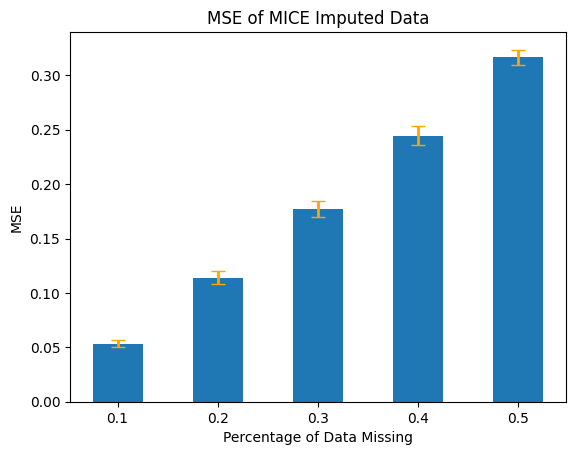

In [ ]:
fig, ax = plt.subplots(1)

ax.bar(np.arange(1, 6, 1)/10, np.mean(mse, axis=1), width=0.05)
# ax.plot(np.arange(1,6,1)/10, np.mean(mse, axis=1))
ax.errorbar(np.arange(1,6,1)/10, np.mean(mse, axis=1), np.std(mse, axis=1),
            linestyle ='', c='orange', capsize=5, elinewidth=2)
ax.set_xlabel('Percentage of Data Missing')
ax.set_ylabel('MSE')
ax.set_title('MSE of MICE Imputed Data')
plt.show(fig)

# Step 5) Run the simulations!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

def GetAccuracy(x_full, al_model):
    x_train, y_train = al_model.getTrainData()
    al_model.clf.fit(x_train,y_train)
    x_test, y_test = x_full[al_model.test_idx], al_model.y[al_model.test_idx]
    pred = al_model.clf.predict(x_test)
    return accuracy_score(y_test, pred)

def RunOneSimulation(x_full, al_model, num_rounds):
  """
  x_full: The full data. No missing values. (n, f) matrix.

  al_model: A active learning model. Should have a method "ChooseNextImputeValue" that returns a tuple of lists.
  (i, j, values) where i and j are list of row and column indicies and values is a list containing the values
  that should be used to replace the nan at a given i,j.
  """
  accuracies = [GetAccuracy(x_full, al_model)]
  impute_record = []

  progress_bar = tqdm(range(num_rounds), position=0, ncols=80, leave=True)
  for i in progress_bar:
    nextImputeValues = al_model.ChooseNextImputeValue()
    impute_record.append(nextImputeValues)
    i, j = nextImputeValues
    val = x_full[i,j]
    # print(f'Next imputed value at: {i, j}. Value is {val}')
    al_model.UpdateTrainSet(i, j, val)
    # progress_bar.set_postfix({"Accuracy": acc})
    accuracies.append(GetAccuracy(x_full, al_model))
  return accuracies

def RunAllSimulations(x_full, x_mult_sim, y, train_idx_mult_sim, test_idx_mult_sim, al_model, clf, end_proportion, filepath):
  """
  x_full: The full data. No missing values. (n, f) matrix.

  x_mult_sim: The nan masked data for each simulation. (s, n, f) matrix.
  s = number of simulations, n = number of samples, f = number of features

  y: the labels. n length array. n = number of samples

  train_idx_mult_sim: The indicies of the trainings set for each simulation
  test_idx_mult_sim: The indicies of the testing set for each simulation

  clf: sklearn estimator
  end_proportion: Continue the AL simulation until the percentage of nans reaches this value.

  filepath: location to save the results of the run.
  """
  s,n,f = x_mult_sim.shape

  accuracies = []
  # progress_bar = tqdm(range(s), position=0, ncols=80, leave=True)
  for i in range(s):
    # progress_bar.set_description('Simulation %d' %i)

    train_test_idx = (train_idx_mult_sim[i], test_idx_mult_sim[i])
    model = al_model(x_mult_sim[i], y, train_test_idxs=train_test_idx, classifier=clf)
    train_data, _ = model.getTrainData()

    init_proportion = np.isnan(train_data).sum()/train_data.size
    num_rounds = int(np.ceil((round(init_proportion*train_data.size) - round(end_proportion*train_data.size))/model.batch_size))

    acc = RunOneSimulation(x_full, model, num_rounds)
    accuracies.append(acc)

    padded_accuracies = PadList(accuracies)
    np.save(filepath, padded_accuracies)

  return accuracies

def PadList(list0):
  """
  pads a list of lists with np.nan values so that each inner list has the same length.
  This function puts the np.nans at the start of each inner list.

  Input:
  list0 (list[list]): A list of lists.

  output:
  (list[list])
  """
  max_len = np.max([len(ele) for ele in list0])
  padded_list = []
  for ele in list0:
    if len(ele) < max_len:
      padded_list.append([np.nan]*(max_len-len(ele))+ele)
    else:
      padded_list.append(ele)
  padded_list = np.array(padded_list)

  return padded_list


In [ ]:
p, s, n, f = x_mult_sim.shape
padding=14
print(f'Proportions of data masked : {percents}')
print(f"Number of {'mask percents':<{padding}}: {p}" +
      f"\nNumber of {'simulations':<{padding}}: {s}"+
      f"\nNumber of {'samples':<{padding}}: {n}"+
      f"\nNumber of {'features':<{padding}}: {f}")
padding=15
print(f"Shape of {'x':<{padding}}: {x_mult_sim.shape}"+
      f"\nShape of {'y':<{padding}}: {y.shape}"+
      f"\nShape of {'train_idxs':<{padding}}: {train_idx_mult_sim.shape}"+
      f"\nShape of {'test_idxs':<{padding}}: {test_idx_mult_sim.shape}")

Proportions of data masked : [0.1 0.2 0.3 0.4 0.5]
Number of mask percents : 5
Number of simulations   : 10
Number of samples       : 714
Number of features      : 14
Shape of x              : (5, 10, 714, 14)
Shape of y              : (714,)
Shape of train_idxs     : (10, 74)
Shape of test_idxs      : (10, 640)


Doing single value feature imputation with active learning.

In [ ]:
# Figure out how much of the data contains nans.
chosen_p = 0

avg_init_proportion = 0
for i in range(s):
  train_idx = train_idx_mult_sim[i,:]
  train_data = x_mult_sim[chosen_p,i,train_idx,:]
  init_proportion = np.isnan(train_data).sum()/train_data.size
  avg_init_proportion += init_proportion
  print(f'{100*init_proportion:.5f} % of the data is missing (nan). The training set has shape {train_data.shape}')
avg_init_proportion /= s
print(f'Average percent of missing data is {100*avg_init_proportion:.5f} %')

8.88031 % of the data is missing (nan). The training set has shape (74, 14)
10.13514 % of the data is missing (nan). The training set has shape (74, 14)
9.84556 % of the data is missing (nan). The training set has shape (74, 14)
9.26641 % of the data is missing (nan). The training set has shape (74, 14)
9.36293 % of the data is missing (nan). The training set has shape (74, 14)
9.07336 % of the data is missing (nan). The training set has shape (74, 14)
9.94208 % of the data is missing (nan). The training set has shape (74, 14)
11.29344 % of the data is missing (nan). The training set has shape (74, 14)
10.03861 % of the data is missing (nan). The training set has shape (74, 14)
9.45946 % of the data is missing (nan). The training set has shape (74, 14)
Average percent of missing data is 9.72973 %


Setup some logistic variables.

In [ ]:
end_proportion = 0 # Impute values until only 10% of training data is nan
batch_size = 1
assert end_proportion < init_proportion, "You must end with less nans than you started with you dummy!"
for i in range(s):
  train_idx = train_idx_mult_sim[i,:]
  train_data = x_mult_sim[chosen_p,i,train_idx,:]
  init_proportion = np.isnan(train_data).sum()/train_data.size
  num_rounds = int(np.ceil((round(init_proportion*train_data.size) - round(end_proportion*train_data.size))/batch_size))
  print(f'Simulation {i} will take {num_rounds} rounds.')

Simulation 0 will take 92 rounds.
Simulation 1 will take 105 rounds.
Simulation 2 will take 102 rounds.
Simulation 3 will take 96 rounds.
Simulation 4 will take 97 rounds.
Simulation 5 will take 94 rounds.
Simulation 6 will take 103 rounds.
Simulation 7 will take 117 rounds.
Simulation 8 will take 104 rounds.
Simulation 9 will take 98 rounds.


In [ ]:
classifier = RandomForestClassifier(n_estimators=10, max_depth = 15, random_state=174)

train_idx = np.random.choice(np.arange(n), size=(n-200))
test_idx = np.setdiff1d(np.arange(n), train_idx)
classifier.fit(x[train_idx],y[train_idx])
prob = classifier.predict(x[test_idx])
print(accuracy_score(y[test_idx], prob))

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
for i in range(s):
  train_idx = train_idx_mult_sim[i]
  test_idx = test_idx_mult_sim[i]

  # Accuracy with no missing data
  x_train = x[train_idx,:]
  y_train = y[train_idx]
  x_test = x[test_idx,:]
  y_test = y[test_idx]

  classifier.fit(x_train,y_train)
  prob=classifier.predict(x_test)
  acc = accuracy_score(y_test, prob)

  # Accuracy with missing data
  x_train = x_mult_sim[chosen_p, i, train_idx,:]
  y_train = y[train_idx]
  x_test = x[test_idx,:]
  y_test = y[test_idx]

  classifier.fit(x_train,y_train)
  prob=classifier.predict(x_test)
  nan_acc = accuracy_score(y_test, prob)

  print(f'Accuracy no missing values {acc:0.5f}{"":>4}Accuracy with missing values: {nan_acc:0.5f}{"":>4}Delta:{acc-nan_acc:0.5f}')


Accuracy no missing values 0.41406    Accuracy with missing values: 0.42031    Delta:-0.00625
Accuracy no missing values 0.44688    Accuracy with missing values: 0.50156    Delta:-0.05469
Accuracy no missing values 0.42031    Accuracy with missing values: 0.45937    Delta:-0.03906
Accuracy no missing values 0.45156    Accuracy with missing values: 0.37500    Delta:0.07656
Accuracy no missing values 0.40937    Accuracy with missing values: 0.47656    Delta:-0.06719
Accuracy no missing values 0.46719    Accuracy with missing values: 0.34844    Delta:0.11875
Accuracy no missing values 0.41563    Accuracy with missing values: 0.44062    Delta:-0.02500
Accuracy no missing values 0.38438    Accuracy with missing values: 0.42500    Delta:-0.04062
Accuracy no missing values 0.44062    Accuracy with missing values: 0.43594    Delta:0.00469
Accuracy no missing values 0.44688    Accuracy with missing values: 0.52656    Delta:-0.07969


In [ ]:
# importlib.reload(afva)
# importlib.reload(rfva)
al_model, filepath = afva.SEU_US, directory + '/50_seu_us_results.npy'
# al_model, filepath = afva.SEU_ES, directory + '/seu_es_results.npy'
# al_model, filepath = afva.RFVA, directory + '/rfva_results.npy'

results = RunAllSimulations(x, x_mult_sim[chosen_p], y, train_idx_mult_sim,
                            test_idx_mult_sim,
                            al_model,
                            classifier,
                            end_proportion,
                            filepath)

100%|█████████████████████████████████████████| 110/110 [06:33<00:00,  3.58s/it]


In [ ]:
# al_model, filepath = afva.SEU_US, directory + '/seu_us_results.npy'
al_model, filepath = afva.SEU_ES, directory + '/50_seu_es_results.npy'
# al_model, filepath = afva.RFVA, directory + '/rfva_results.npy'

results = RunAllSimulations(x, x_mult_sim[chosen_p], y, train_idx_mult_sim,
                            test_idx_mult_sim,
                            al_model,
                            classifier,
                            end_proportion,
                            filepath)

100%|█████████████████████████████████████████| 110/110 [06:36<00:00,  3.60s/it]


In [ ]:
# al_model, filepath = afva.SEU_US, directory + '/seu_us_results.npy'
# al_model, filepath = afva.SEU_ES, directory + '/seu_es_results.npy'
al_model, filepath = rfva.RFVA, directory + '/50_rfva_results.npy'

results = RunAllSimulations(x, x_mult_sim[chosen_p], y, train_idx_mult_sim,
                            test_idx_mult_sim,
                            al_model,
                            classifier,
                            end_proportion,
                            filepath)

100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 53.49it/s]


(10, 129)
(10, 129)
(10, 129)


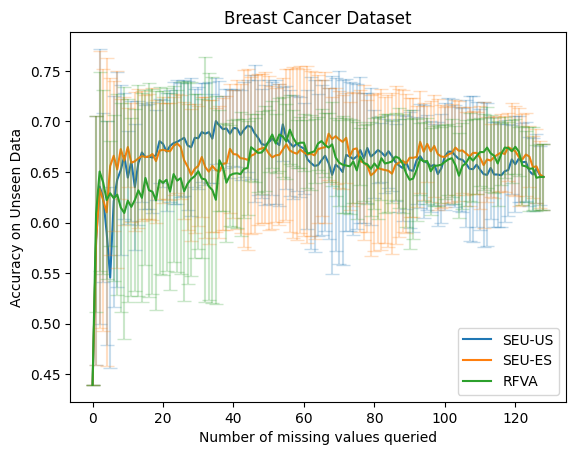

In [ ]:
fig, ax = plt.subplots(1)

directory = root + '/data/breast_cancer'
filepaths = [directory + '/seu_us_results.npy', directory + '/seu_es_results.npy', directory + '/rfva_results.npy']
line_labels = ['SEU-US','SEU-ES', 'RFVA']
all_padded_results = [np.load(filepath) for filepath in filepaths]
for dataset in all_padded_results:
  print(dataset.shape)
for lab, padded_results in zip(line_labels, all_padded_results):
  x_vals=np.arange(padded_results.shape[1])
  y_vals=np.nanmean(padded_results, axis=0)
  y_std=np.nanstd(padded_results, axis=0)
  handle,=ax.plot(x_vals, y_vals, label = lab)
  ax.errorbar(x_vals, y_vals, y_std, linestyle="", alpha=0.25, capsize=5,c=handle.get_color())

# ax.invert_xaxis()
ax.set_title('Breast Cancer Dataset')
ax.set_xlabel('Number of missing values queried')
ax.set_ylabel('Accuracy on Unseen Data')
ax.legend()
plt.show(fig)

Versus the baseline stuff (mean, median, mice).

In [ ]:
def RunBaseline(x_full, x, y, train_idx, test_idx, classifier, impute_method):
  x_train, x_test = x[train_idx], x_full[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  x_train = impute_method(x_train)
  classifier.fit(x_train, y_train)
  preds = classifier.predict(x_test)
  return accuracy_score(y_test, preds)

In [ ]:
importlib.reload(mice)
importlib.reload(basic_impute)
from functools import partial
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

classifier = RandomForestClassifier(n_estimators=10, max_depth = 15, random_state=174)

# impute_method, filepath = partial(mice.ImputeDataMice, classifier=classifier), directory + '/mice_results.npy'
# impute_method, filepath = basic_impute.Imputation_Mean, directory + '/mean_results.npy'
impute_method, filepath = basic_impute.Imputation_Mode, directory + '/mode_results.npy'


accuracies = []
for i in range(p):
  acc = []
  for j in range(s):
    acc.append(RunBaseline(x, x_mult_sim[i,j], y, train_idx_mult_sim[j], test_idx_mult_sim[j], classifier, impute_method))
  accuracies.append(acc)
accuracies = np.array(accuracies)
np.save(filepath, accuracies)

In [ ]:
filepaths = [directory + '/mice_results.npy', directory + '/mean_results.npy', directory + '/mode_results.npy']
labels = ['MICE', 'mean', 'mode']

# fig, ax = plt.subplots()
for filepath in filepaths:
  data = np.load(filepath)
  print(data.shape)
  print(np.mean(data, axis=1))

(5, 10)
[0.68266129 0.69032258 0.66935484 0.65564516 0.65241935]
(5, 10)
[0.6875     0.6733871  0.67943548 0.65766129 0.66532258]
(5, 10)
[0.67822581 0.67096774 0.67137097 0.66612903 0.66653226]
